In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
import matplotlib.animation as animation
from pylab import *

In [2]:
mean = np.array([1,-2,3])
cov= np.array([[10,4,1],
       [4, 12, 3],
       [1, 3, 10]])
norm = np.random.multivariate_normal(mean = mean, cov = cov, size = 10000)
class1=[]
class2=[]
def division_formula(norm, mean, cov):
    res = ((norm - mean).T).dot(np.linalg.inv(cov)).dot((norm - mean))
    return res
def classy(cov, mean, norm, d = 0.01, eps = 0.4):
    A = []
    for i in norm:
        a = division_formula(i, mean, cov)
        A.append(a)
    class1_idx = np.concatenate(np.argwhere(A >= ((sum(cov.diagonal()) * d)*(1+eps))))
    class1_idx = np.random.choice(class1_idx, size=1000, replace=True)
    X1 = norm[class1_idx, :]
    class2_idx = np.concatenate(np.argwhere(A <= (sum(cov.diagonal()) * d*(1-eps))))
    class2_idx = np.random.choice(class2_idx, size=1000, replace=True)
    X2 = norm[class2_idx, :]
    return X1,X2

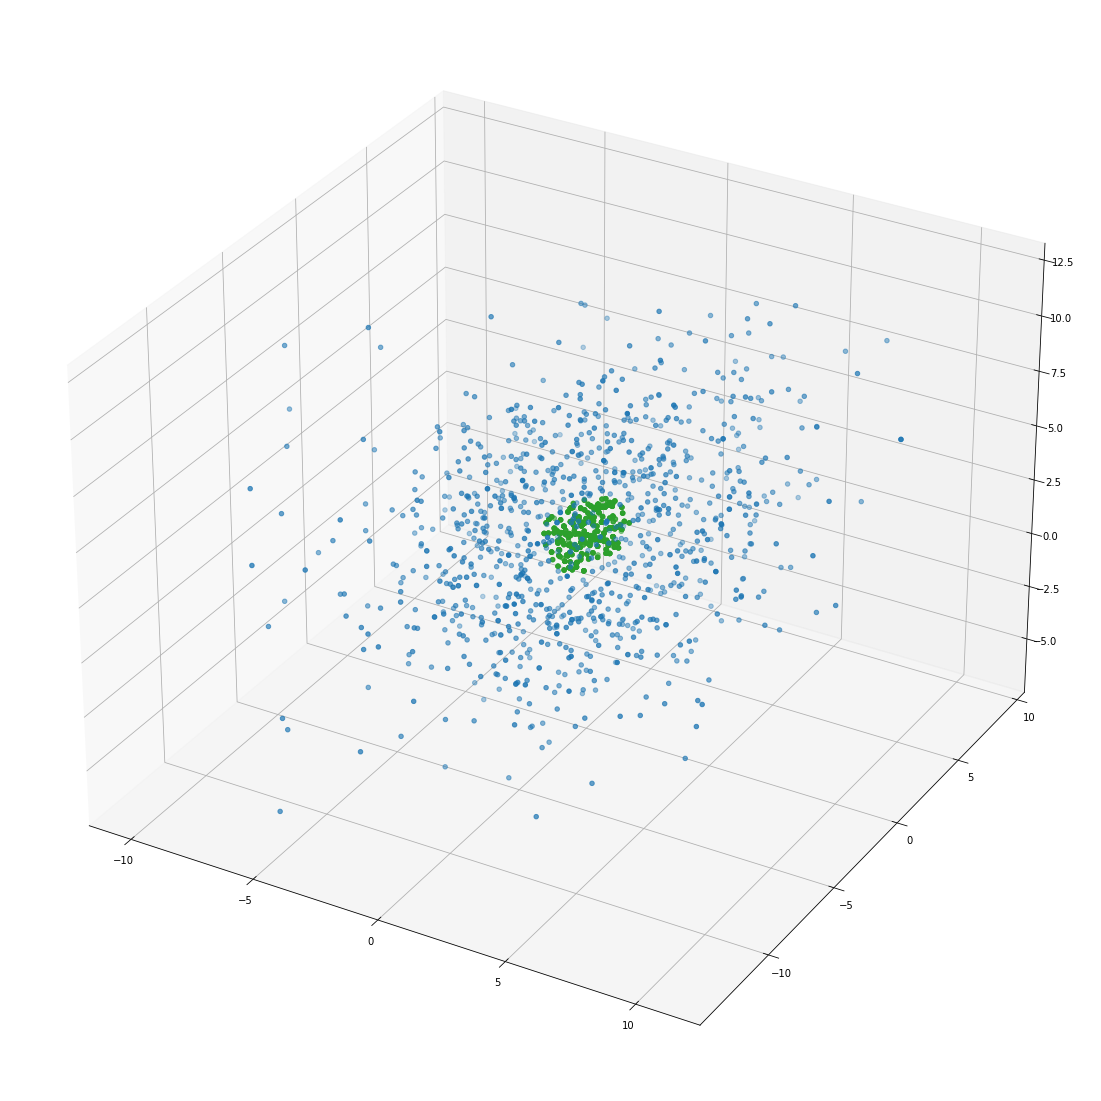

1000
1000


In [3]:
def plot_data(data,cov,mean):
    data1,data2 = classy(cov,mean,norm, d = 0.01, eps = 0.4)
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data1[:,0], data1[:,1], data1[:,2],c = '#1f77b4')
    ax.scatter(data2[:,0], data2[:,1], data2[:,2],c = '#2ca02c')
    plt.show()
    return data1,data2
X1,X2 = classy(cov, mean, norm, d = 0.01, eps = 0.4)
data1,data2 = plot_data(norm,cov,mean)
print(data1.shape[0])
print(data2.shape[0])

In [18]:
def check_eig(alpha):
        dim = X.shape[1]
        A = np.reshape(alpha[:dim**2], newshape=(dim, dim))
        v, l = np.linalg.eigh(A)
        l_all = [l[:, i] for i in range(len(l))]
        for i in range(len(l)):
            eta_l = np.einsum('i,j->ij', l_all[i], l_all[i]).ravel()
            eta_l = np.concatenate((eta_l, np.zeros(len(l_all[i])+1)))
        return eta_l, v

def fit(X, y):
    n_iter = 0
    dim = X.shape[1]
    alpha = np.zeros(dim**2+dim+1)
    correction_isneeded = True
    while (correction_isneeded):
        n_iter +=1
        correction_isneeded = False
        for xi, target in zip(X, y):
            ksi_i = np.einsum('i,j->ij', xi, xi).ravel()
            ksi_i = np.concatenate((ksi_i, xi, [1]))
            alpha_ksi = np.dot(ksi_i,alpha)
            if alpha_ksi >= 0 and target == 1:
                correction_isneeded = True
                alpha -= ksi_i
            elif alpha_ksi <= 0 and target == 0:
                correction_isneeded = True
                alpha += ksi_i
        if not correction_isneeded:            
            eta_l, eig_vals = check_eig(alpha)
            for i in range(len(eig_vals)):
                if eig_vals[i] <= 0:
                    alpha = alpha + eta_l[i]
                    correction_isneeded = True
                    break
    return alpha,n_iter
    
def predict(X,alpha):
    ksi_pred = np.zeros((X.shape[0], X.shape[1]**2+X.shape[1]+1))
    k = 0
    for xi in X:
        ksi_pred_i = np.einsum('i,j->ij', xi, xi).ravel()
        ksi_pred_i = np.concatenate((ksi_pred_i, xi, [1]))
        ksi_pred[k] = ksi_pred_i
        k += 1
    return np.where(np.dot(ksi_pred, alpha) >= 0.0, 0, 1)
    
def find_dist_params(alpha):
    dim = X.shape[1]
    Sigma_inv = np.reshape(alpha[:dim**2], newshape=(dim, dim))
    B = np.array([b/(-2) for b in alpha[dim**2:dim**2+dim]])
    mu = np.linalg.solve(Sigma_inv, B)
    return mu, np.linalg.inv(Sigma_inv)

def create_dataframe(sample1, sample2): 
    columns_names = ['x{}'.format(i) for i in range(sample1.shape[1])]
    df1 = pd.DataFrame(sample1, columns = [*columns_names])
    df1['target'] = 0
    df2 = pd.DataFrame(sample2, columns = [*columns_names])
    df2['target'] = 1
    return  df1.append(df2)

In [19]:
from sklearn.utils import shuffle
df = create_dataframe(X1,X2)
df1 = shuffle(df,random_state=42)
X = df1.drop('target', 1)
y = df1['target']
X_new = X.values
y_new = y.values
cl, iters = fit(X_new,y_new)
prediction = predict(X_new,cl)
print(f'accuracy of the classifier:  {accuracy_score(prediction, y_new)}')
mean_pred, cov_pred = find_dist_params(cl)
print(f'\nmean predicted: {mean_pred}')
print(f'\ncov predicted:\n {cov_pred}')
print(f'\nclasifier steps:    {iters}')
#df_shuffle, X, y = data_shuffle(df)
#X_new = X.values
#y_new = y.values

C:\Users\9234~1\AppData\Local\Temp/ipykernel_8172/1705790551.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df1.drop('target', 1)


accuracy of the classifier:  1.0

mean predicted: [ 0.93147008 -1.62433532  2.899373  ]

cov predicted:
 [[0.00697079 0.00135283 0.00148799]
 [0.00135283 0.00948055 0.0002592 ]
 [0.00148799 0.0002592  0.00748048]]

clasifier steps:    733


In [20]:
if np.argwhere(prediction == 0).any(): 
    X12 = X_new[np.concatenate(np.argwhere(prediction == 0))]
else:
    X12 = X_new
if np.argwhere(prediction == 1).any():
    X22 = X_new[np.concatenate(np.argwhere(prediction == 1))]
else:
    X22 = X_new

In [21]:
def plott_datta(X1, X2, figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    ax= fig.add_subplot(111, projection='3d')
    ax.scatter3D(X1[:,0], X1[:,1], X1[:,2], color='yellow' );
    ax.scatter3D(X2[:,0], X2[:,1], X2[:,2], color='blue');
    plt.show()

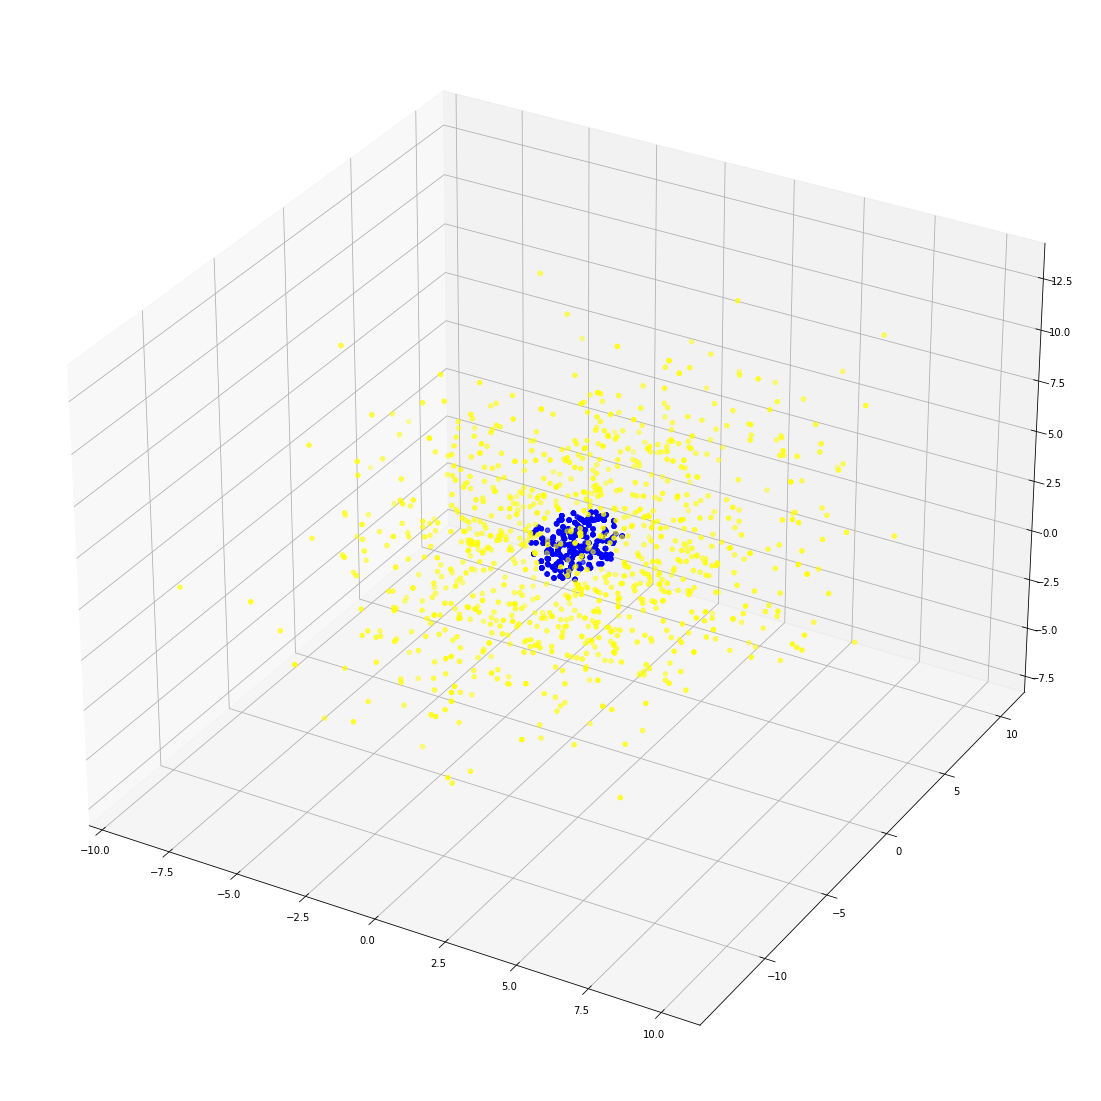

In [22]:
plott_datta(X12, X22)